In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  
import pandas as pd
import scipy.sparse as sps

from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [2]:
def load_URM(file_path):

    data = pd.read_csv(file_path)


    user_list = data['row'].tolist()
    item_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (user_list, item_list))).tocsr()

In [3]:
def load_ICM(file_path):

    data = pd.read_csv(file_path)

    item_list = data['row'].tolist()
    attribute_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (item_list, attribute_list))).tocsr()

In [4]:
URM_all = load_URM('input/data_train.csv')
ICM_all = load_ICM('input/data_ICM_subgenre.csv')
#print(ICM_all)

In [5]:
ICM_all.shape

(18059, 113)

In [6]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [7]:
print(features_per_item.shape)
print(items_per_feature.shape)

(18059,)
(113,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

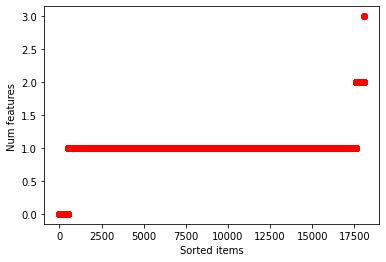

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

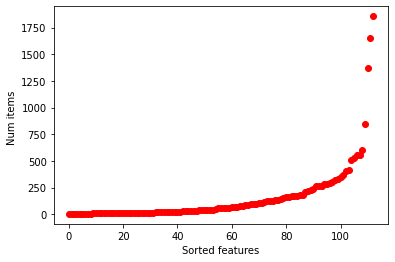

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13647 ( 0.0%) Users that have less than 1 test interactions


In [12]:
#import traceback

#try:
#    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
#except Exception as e:
#    traceback.print_exc()

In [13]:
#block_size = 100

#numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
#numerator_block.shape

In [14]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 18059 (100.0%), 7695.68 column/sec. Elapsed time 2.35 sec


<18059x18059 sparse matrix of type '<class 'numpy.float32'>'
	with 1679710 stored elements in Compressed Sparse Row format>

In [15]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores


In [16]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 18059 (100.0%), 7826.88 column/sec. Elapsed time 2.31 sec


In [17]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[6728 6514 6615 8033 7873]
[14159  3937  8716  3885  6250]
[7873 8111 6597 7968 8033]
[10554 17049  4276  4564  9832]
[15507  6728 10182  8111  8033]
[ 6811  1255 10866 14818 12545]
[  803  7051 10726  2440 17236]
[14661  8323  5255 10454 10203]
[ 2298  8242 14449  9726 10267]
[12365  4148  5190  4399  4904]


# Hyperparameters tuning

## Number of neighbors

In [18]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8278.49 column/sec. Elapsed time 2.18 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 3.89 sec. Users per second: 3505
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7879.27 column/sec. Elapsed time 2.29 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 5.13 sec. Users per second: 2660
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7680.34 column/sec. Elapsed time 2.35 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 6.00 sec. Users per second: 2273
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python

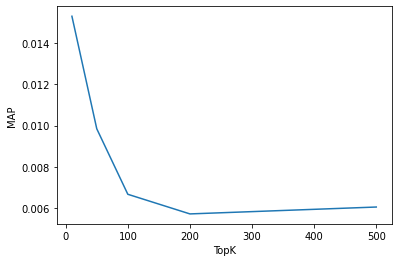

In [19]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### So we should take TopK = 100 (I guess)

## Shrinkage

In [20]:
x_tick = range(0,11)
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8705.03 column/sec. Elapsed time 2.07 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 5.57 sec. Users per second: 2449
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8498.04 column/sec. Elapsed time 2.13 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 5.49 sec. Users per second: 2487
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8699.45 column/sec. Elapsed time 2.08 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 5.47 sec. Users per second: 2493
ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python

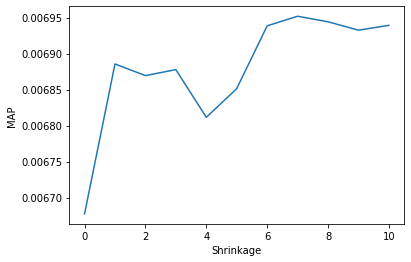

In [21]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### ...dafuq?

# Feature weighting

## IDF

In [22]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(18059, 113)
(113,)


In [23]:
np.sort(items_per_feature)

array([   3,    5,    5,    5,    5,    5,    6,    6,    6,    7,    7,
          8,    8,    8,    9,    9,    9,   10,   10,   10,   10,   11,
         14,   14,   14,   14,   14,   14,   15,   16,   16,   16,   17,
         17,   18,   18,   19,   19,   20,   23,   24,   24,   27,   28,
         29,   30,   32,   35,   36,   40,   42,   42,   43,   44,   50,
         54,   56,   57,   58,   59,   67,   71,   71,   78,   80,   86,
         90,   94,   94,   98,  106,  110,  117,  121,  122,  127,  133,
        136,  140,  154,  162,  162,  170,  173,  174,  176,  183,  207,
        219,  231,  232,  264,  267,  268,  279,  285,  292,  301,  321,
        329,  347,  366,  402,  415,  504,  528,  551,  556,  604,  845,
       1371, 1652, 1856], dtype=int32)

In [24]:
np.sort(IDF)

array([2.27522054, 2.3916575 , 2.57810377, 3.06206283, 3.39782526,
       3.48063116, 3.48966465, 3.53230317, 3.57882319, 3.77312093,
       3.80494737, 3.89876612, 3.95207467, 4.0053417 , 4.02995833,
       4.09428919, 4.12464565, 4.14891027, 4.17018767, 4.21041247,
       4.2141508 , 4.22545035, 4.35466208, 4.35898174, 4.41232772,
       4.46868066, 4.5919133 , 4.63091546, 4.64234416, 4.64810786,
       4.66560102, 4.71380312, 4.71380312, 4.76444685, 4.85975703,
       4.88874457, 4.91105033, 4.95721237, 4.99737841, 5.00560891,
       5.03922552, 5.10091909, 5.13796036, 5.21643198, 5.25810467,
       5.25810467, 5.30158978, 5.34705216, 5.41937282, 5.44469063,
       5.53871958, 5.53871958, 5.59670684, 5.72386201, 5.74095644,
       5.75834819, 5.77604776, 5.81241541, 5.88937645, 6.01720982,
       6.04019934, 6.06372984, 6.06372984, 6.11252   , 6.21788052,
       6.24605139, 6.33566355, 6.40020207, 6.43410362, 6.46919494,
       6.50556259, 6.62334562, 6.62334562, 6.66590524, 6.80566

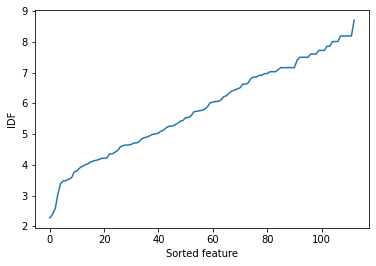

In [25]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

In [26]:
from scipy.sparse import diags
diags(IDF)

<113x113 sparse matrix of type '<class 'numpy.float64'>'
	with 113 stored elements (1 diagonals) in DIAgonal format>

In [27]:
ICM_idf = ICM_all.copy()
ICM_idf = ICM_idf*diags(IDF)

In [28]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=7.0, topK=100)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8674.56 column/sec. Elapsed time 2.08 sec
EvaluatorHoldout: Processed 13647 (100.0%) in 5.05 sec. Users per second: 2700


PRECISION                      0.034015
PRECISION_RECALL_MIN_DEN       0.034033
RECALL                         0.004766
MAP                            0.010742
MAP_MIN_DEN                    0.010745
MRR                            0.082179
NDCG                           0.033024
F1                              0.00836
HIT_RATE                       0.267824
ARHR_ALL_HITS                  0.093917
NOVELTY                        0.007811
AVERAGE_POPULARITY             0.095984
DIVERSITY_MEAN_INTER_LIST      0.975769
DIVERSITY_HERFINDAHL            0.99757
COVERAGE_ITEM                  0.414696
COVERAGE_ITEM_CORRECT          0.055097
COVERAGE_USER                   0.99978
COVERAGE_USER_CORRECT          0.267766
DIVERSITY_GINI                 0.077686
SHANNON_ENTROPY               10.315451
RATIO_DIVERSITY_HERFINDAHL     0.997955
RATIO_DIVERSITY_GINI           0.313475
RATIO_SHANNON_ENTROPY          0.832597
RATIO_AVERAGE_POPULARITY       0.471285
RATIO_NOVELTY                  0.045938


#### Alternative feature weighting: BM25

# ...

In [29]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

ItemKNNCBFRecommender: ICM Detected 487 ( 2.7%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 8829.46 column/sec. Elapsed time 2.05 sec


In [34]:
import pandas as pd
from tqdm import tqdm
submission = pd.DataFrame(columns=['user_id', 'item_list'])

for i in tqdm(range(13650), desc="getting recommendations"):
    item_list = recommender.recommend(i, 10)
    submission.loc[i] = [i, ' '.join([str(i) for i in item_list])]

submission

getting recommendations: 100%|██████████| 13650/13650 [00:18<00:00, 740.94it/s]


,user_id,item_list
0,0,6728 6615 8111 6514 8033 7873 7968 10181 7464 ...
1,1,8602 12784 6577 5999 16620 9747 2052 552 8756 ...
2,2,6597 8033 8111 6514 6728 7968 6615 7873 12995 ...
3,3,11537 11060 11596 11311 275 10507 12531 3253 1...
4,4,7968 6597 7873 17450 10181 6728 6615 10182 651...
...,...,...
13645,13645,15922 4837 15831 13630 8898 5819 17553 5141 14...
13646,13646,5241 2448 2555 5317 5292 5247 5635 2478 2326 2393
13647,13647,15346 17780 12967 6811 15237 7276 17776 13028 ...
13648,13648,2996 823 1013 11480 2979 3804 1040 1843 3814 3889


In [35]:
from datetime import datetime
submission.to_csv(f'output/cbf_subgenre_{str(datetime.now())}.csv', index=False)